# StackOverflow - Exploratory Data Analysis

Perform an Exploratory Data Analysis over the data included in the BigQuery dataset `bigquery-public-data.stackoverflow`, in order to uncover interesting patterns and potential use cases within the data.

# Setup Notebook

## Imports

In [22]:
# Import Standard Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pandas as pd
import seaborn as sns
from colorama import Style, Fore
from matplotlib.gridspec import GridSpec
from pathlib import Path
from dynaconf import Dynaconf
from scipy.stats import zscore

# Import Package Modules
from src.bigquery_connector.bigquery_connector import BigQueryConnector
from src.types import BigQueryClientConfig

## Setup Plot Characteristics

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

## Define Configurations

In [4]:
# Setup root path
root_path = Path(os.getcwd()).parents[2]

In [5]:
# Read configuration
config = Dynaconf(
    settings_files=[
        root_path / 'configuration' / 'settings.toml'
    ],
    environments=True, 
    env='eda'
)

In [6]:
# Retrieve configurations
read_local = config['read_local']
bigquery_client_config = config['bigquery_client']
relevant_users_config = config['relevant_users']

# Read Data

In [7]:
# Switch between reading from local .CSV files or from BigQuery tables
if read_local:
    # Read from local .CSV files
    relevant_users = pd.read_csv(root_path / relevant_users_config['local_path']).iloc[:, 2:] # Skip IDs columns
else:
    # Instance BigQuery Connector
    bigquery_connector = BigQueryConnector(BigQueryClientConfig(**bigquery_client_config))
    
    # Read data from BigQuery
    relevant_users = bigquery_connector.read_from_query_config(relevant_users_config)

# Exploratory Data Analysis

## Relevant Users

### General

In [8]:
relevant_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33517 entries, 0 to 33516
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   display_name       33514 non-null  object 
 1   about_me           16121 non-null  object 
 2   age                0 non-null      float64
 3   creation_date      33517 non-null  object 
 4   last_access_date   33517 non-null  object 
 5   location           33506 non-null  object 
 6   reputation         33517 non-null  int64  
 7   up_votes           33517 non-null  int64  
 8   down_votes         33517 non-null  int64  
 9   views              33517 non-null  int64  
 10  profile_image_url  25984 non-null  object 
 11  website_url        10809 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 3.1+ MB


In [9]:
relevant_users.sample(5)

,display_name,about_me,age,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,profile_image_url,website_url
15175,Allen,"<p>Smashing keys, making cool shit</p>",NaN,2014-06-07 19:07:59.960000+00:00,2022-09-25 05:25:16.973000+00:00,"Las Vegas, NV, United States",181,8,0,5,https://i.stack.imgur.com/kXa3L.png?s=128&g=1,NaN
33104,Cem EKIZ,NaN,NaN,2021-10-22 08:29:22.510000+00:00,2022-09-25 02:19:59.447000+00:00,"Paris, France",1,0,0,1,https://lh3.googleusercontent.com/a/AATXAJz7G4...,NaN
28646,Roi,"<pre><code>17 y/o, Wannabe Linux kernel contri...",NaN,2020-07-26 13:27:58.037000+00:00,2022-09-25 04:51:44.447000+00:00,Israel,511,17,4,103,https://i.stack.imgur.com/Zei4v.jpg,NaN
29193,Lucas Lopes de Souza Guilha,"<p>O Like to Solve problems, to think about so...",NaN,2021-09-21 18:41:28.630000+00:00,2022-09-25 04:54:47.093000+00:00,Brazil,1,0,0,1,https://i.stack.imgur.com/CQs7s.png,NaN
25352,pascalin,NaN,NaN,2013-12-23 23:48:44.063000+00:00,2022-09-25 01:51:43.333000+00:00,"Mexico City, México",1,0,0,2,NaN,https://plus.google.com/+DavidSuarezP


In [10]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- All Data -> {red}{relevant_users.shape}\n')

Data Shapes:
- All Data -> (33517, 12)



In [11]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- All Data -> {red}{relevant_users.isnull().any().sum()}\n')

Data Columns with Null Values:
- All Data -> 6



### Null Values

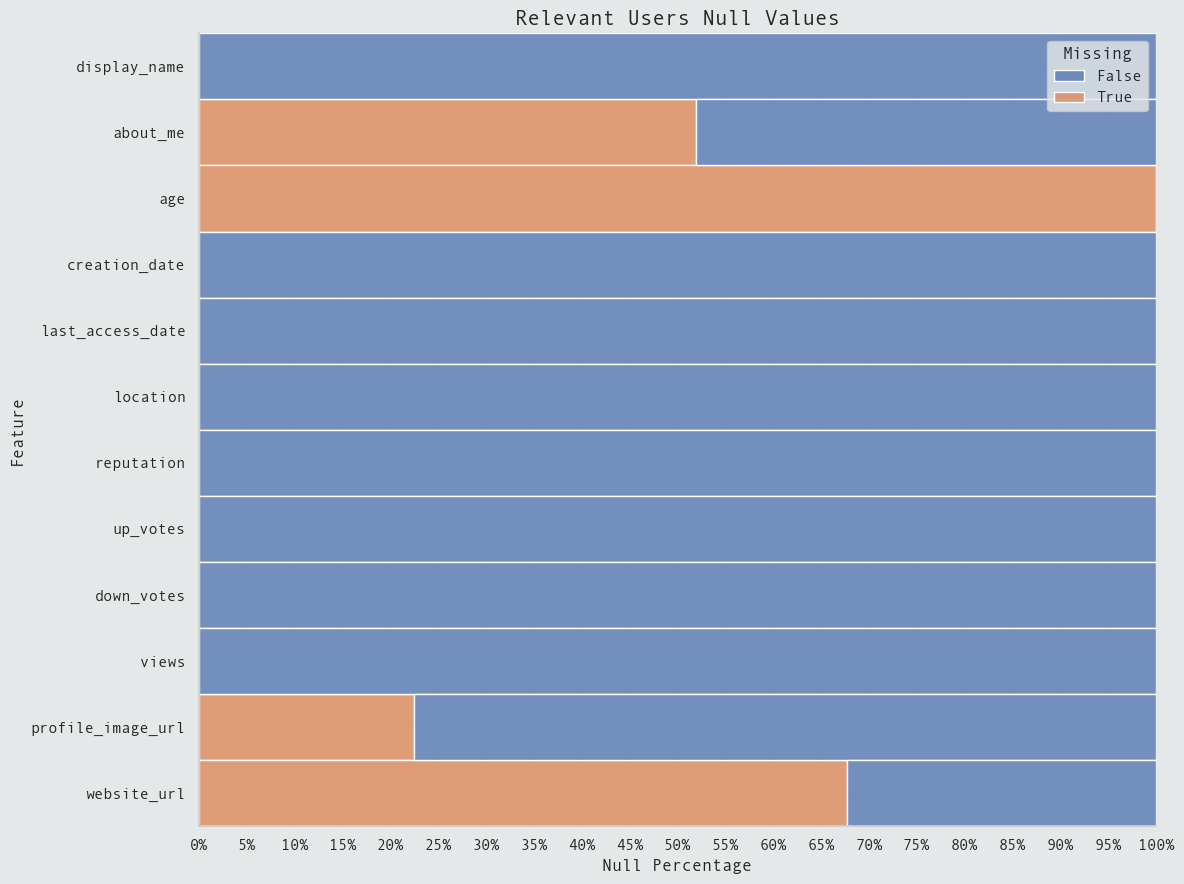

In [12]:
# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(1, 1)

# Plot data
ax = figure.add_subplot(grid_spec[0, 0])

sns.histplot(data=relevant_users.isna().melt(var_name='Feature', value_name='Missing'), 
             y='Feature', 
             hue='Missing', 
             multiple='fill',
             ax=ax)

# Refactor x label as missing percentage
ax.xaxis.set_major_locator(ticker.LinearLocator(21))
ax.xaxis.set_major_formatter('{:.0%}'.format)

# Set title and label
ax.set_title('Relevant Users Null Values', fontsize=15)
ax.set_xlabel('Null Percentage')

plt.show()

- The `age` column is full of null &rarr; Drop it
- The `about_me` is only filled for 50% of the users &rarr; Not possible to use it as a feature

### Numerical Feature Distribution

In [13]:
# Define raw numerical features
raw_numerical_features = [
    'reputation',
    'up_votes',
    'down_votes',
    'views'
]

In [17]:
# Retrieve statistical information
relevant_users[raw_numerical_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
reputation,33517.0,3910.719277,24758.850421,1.0,11.0,128.0,1097.0,1156679.0
up_votes,33517.0,331.055643,1266.953669,0.0,0.0,18.0,166.0,66690.0
down_votes,33517.0,122.266104,1938.247387,0.0,0.0,0.0,5.0,153599.0
views,33517.0,506.298326,5186.963029,0.0,3.0,21.0,129.0,476220.0


- Numerical features have a very high Standard Deviation and different scales &rarr; Require Standardisation

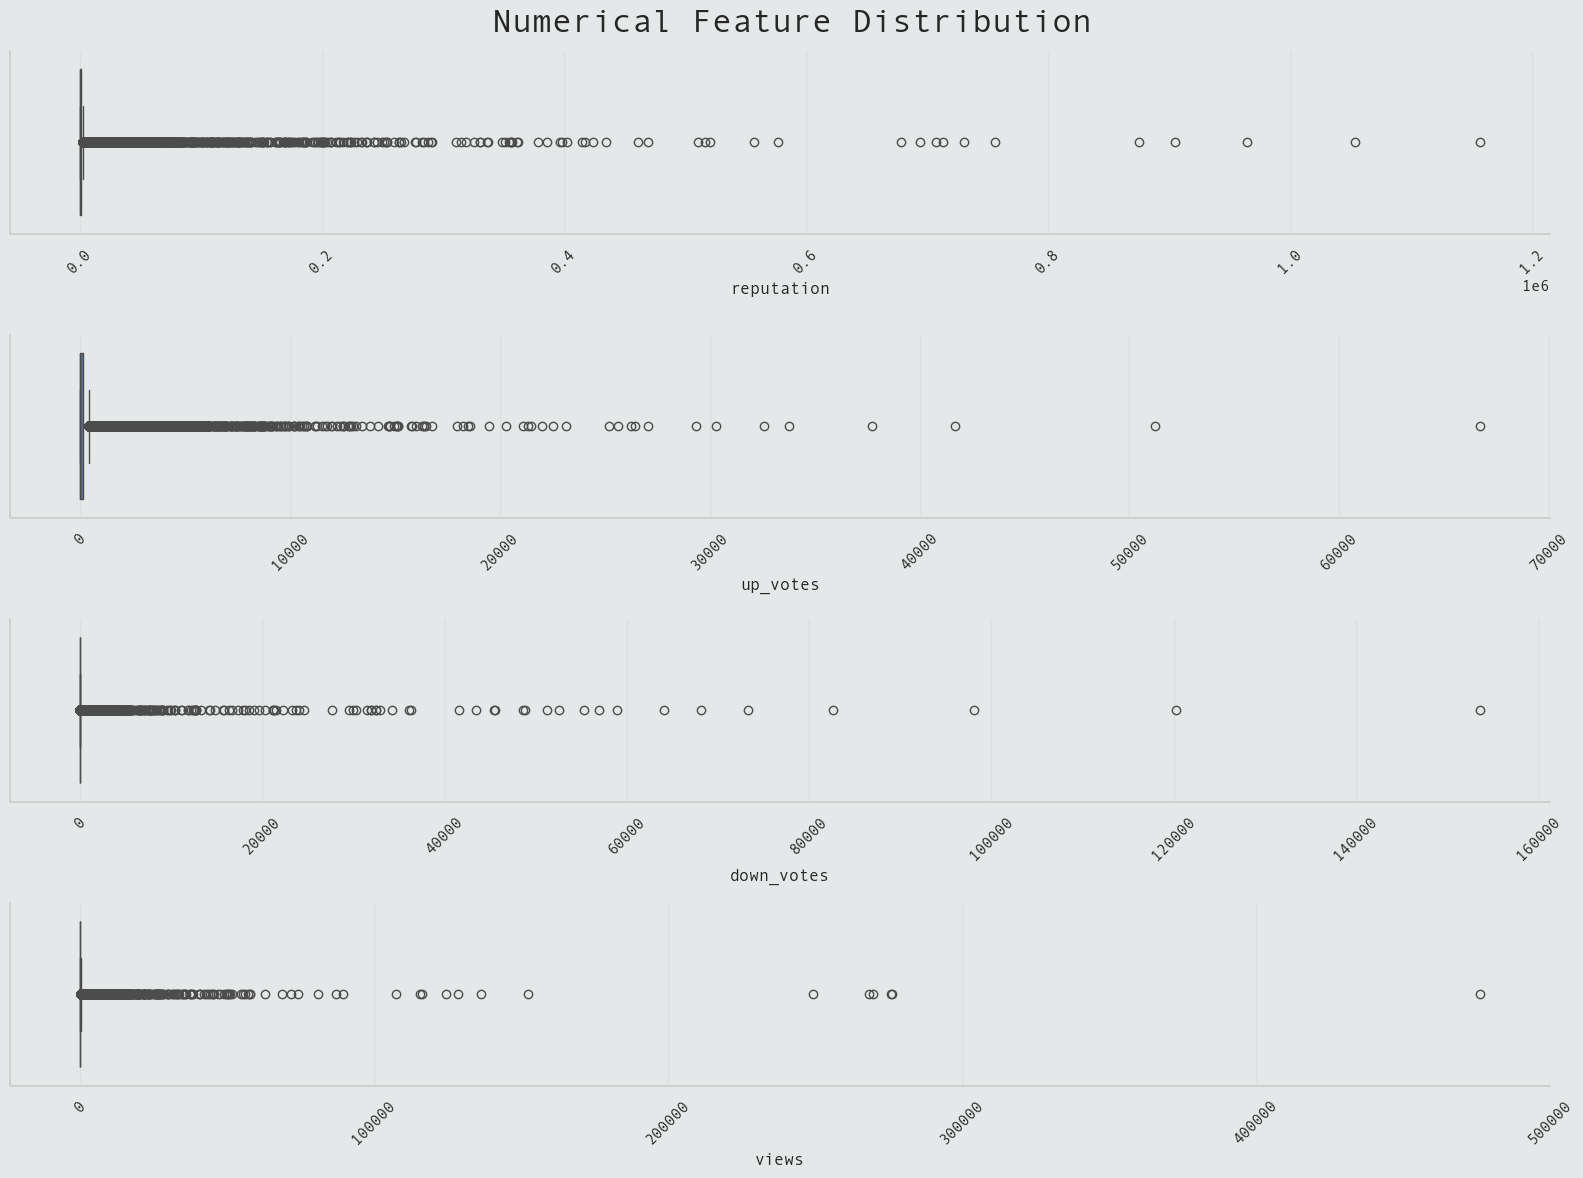

In [21]:
# Define figure and axis
figure, ax = plt.subplots(4, 1, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.boxplot(data=relevant_users,
                x=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- There are quite few outliers, let's count how many hof them through the z-score

In [28]:
# Compute the z-score
z_scores = relevant_users[raw_numerical_features].apply(zscore)

# Identify outliers (greater than 2 Standard Deviations
outliers_count = (z_scores.abs() > 2).sum()

# Display the result as a DataFrame
outliers_df = pd.DataFrame({
    'name': outliers_count.index,
    'outlier_count': outliers_count.values
})

print(outliers_df)

         name  outlier_count
0  reputation            453
1    up_votes            769
2  down_votes            172
3       views            247


- Since they are not too many, we can safely drop them